# Runtime and accuracy scaling experiments

For each grammar type (dependency vs constituency), parsing strategy (MIP vs IP), and grammar complexity (by changing the max # number of pairs / singles supported in the grammar), generate a bunch of random environments and collect the top 10 parses. Save out these results for plotting and data analysis. 

In [6]:
%load_ext autoreload
%autoreload 2

from collections import namedtuple
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *

# DEPENDENCY
DEPENDENCY = 0
if DEPENDENCY:
    from spatial_scene_grammars_examples.singles_pairs.grammar_dependency import *
else:
    from spatial_scene_grammars_examples.singles_pairs.grammar_constituency import *
    
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *

import meshcat
import meshcat.geometry as meshcat_geom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Scripts for doing sample runs; warning, long-running

In [7]:
# Was tempted to use a class here, but it gives trouble with pickling
# unpickling interacting with autoreload. So, ugly dict it is...
def make_parsinginfo_dict(
    gt_tree, gt_tree_score,
    mip_trees, mip_tree_scores,
    nlp_trees, nlp_tree_scores,
    success, mip_time, nlp_time
):
    return {
        "gt_tree": gt_tree,
        "gt_tree_score": gt_tree_score,
        "mip_trees": mip_trees,
        "mip_tree_scores": mip_tree_scores,
        "nlp_trees": nlp_trees,
        "nlp_tree_scores": nlp_tree_scores,
        "success": success,
        "mip_time": mip_time,
        "nlp_time": nlp_time
    }

def parse_random_scenes(N_scenes, N_solutions, strategy):
    assert strategy in ["mip", "ip"]
    
    grammar = SpatialSceneGrammar(
        root_node_type = Root,
        root_node_tf = torch.eye(4)
    )
    parsing_infos = []
    for k in tqdm(range(N_scenes), desc="Samples"):
        gt_tree = grammar.sample_tree(detach=True)
        observed_nodes = gt_tree.get_observed_nodes()
        
        start = time.time()
        if strategy == "mip":
            inference_results = infer_mle_tree_with_mip(
                grammar, observed_nodes, verbose=False, max_scene_extent_in_any_dir=10., N_solutions=10
            )
            parse_trees = get_optimized_trees_from_mip_results(inference_results)
            
        elif strategy == "ip":
            proposed_poses_by_type = generate_candidate_node_pose_sets(
                grammar, observed_nodes, max_recursion_depth=10, verbose=False
            )
            parse_trees = infer_mle_tree_with_mip_from_proposals(
                grammar, observed_nodes, proposed_poses_by_type, verbose=False, N_solutions=N_solutions,
                min_ll_for_consideration=-1000.
            )
        mip_done = time.time()
        
        # NLP refinement
        refined_trees = []
        for tree in parse_trees:
            refinement_result = optimize_scene_tree_with_nlp(grammar, tree, verbose=False)
            if not refinement_result.optim_result.is_success():
                logging.warning("NLP refinement failed.")
            refined_trees.append(refinement_result.refined_tree)
        nlp_done = time.time()
        
        if len(parse_trees) == 0:
            logging.error("Failed an inference! Results invalid")
            parsing_infos.append(
                make_parsinginfo_dict(
                    gt_tree=gt_tree,
                    gt_tree_score=0.,
                    mip_trees=[],
                    mip_tree_scores=[],
                    nlp_trees=[],
                    nlp_tree_scores=[],
                    success=False,
                    mip_time=0,
                    nlp_time=0
                )
            )
        else:
            parsing_infos.append(
                make_parsinginfo_dict(
                    gt_tree=cleanup_tree_for_pickling(gt_tree),
                    gt_tree_score=gt_tree.score(),
                    mip_trees=[cleanup_tree_for_pickling(tree) for tree in parse_trees],
                    mip_tree_scores=[tree.score() for tree in parse_trees],
                    nlp_trees=[cleanup_tree_for_pickling(tree) for tree in refined_trees],
                    nlp_tree_scores=[tree.score() for tree in refined_trees],
                    success=True,
                    mip_time=mip_done-start,
                    nlp_time=nlp_done-mip_done
                )
            )
    return parsing_infos

In [8]:
# Run both techniques against this grammar type for a range
# of MAX_N_PAIRS and MAX_N_SINGLES, which affect the grammar
# "complexity" and typical resulting scene size. Key results
# by that setting.

# Dependency: 1-6 or 7 is reasonable, with patience I might get to 8-10.
# Constituency: 1-3 or 1-4. We're in exponential regime.

results_by_strategy = {}

if DEPENDENCY:
    grammar_sizes = range(1, 7)
else:
    grammar_sizes = range(1, 4)
bar = tqdm(["ip", "mip"])
for strategy in bar:
    bar.set_description("technique: ", strategy)
    results_by_param = {}
    for k in tqdm(grammar_sizes, desc="MAX_N_PAIRS/MAX_N_SINGLES"):
        Pairs.MAX_N_PAIRS = k
        Pairs.P = 0.01 # Basically uniform distribution over # of pairs
        Singles.MAX_N_SINGLES = k
        Singles.P = 0.01 # Basically uniform distribution over # of pairs
        results_by_param[k] = parse_random_scenes(N_solutions=10, N_scenes=20, strategy=strategy)
    results_by_strategy[strategy] = results_by_param

In [10]:
if DEPENDENCY:
    file = "dependency_scaling_random_runs.pickle"
else:
    file = "constituency_scaling_random_runs.pickle"

OVERWRITE = 1
if os.path.exists(file) and not OVERWRITE:
    # Merge into existing results
    with open(file, "rb") as f:
        existing_results = pickle.load(f)
    for strat_key, results in results_by_strategy.items():
        if strat_key not in existing_results.keys():
            existing_results[strat_key] = {}
        print(strat_key, results.keys())
        for key, value in results.items():
            if key in existing_results[strat_key].keys():
                existing_results[strat_key][key] += value
            else:
                existing_results[strat_key][key] = value
    results_by_strategy = existing_results

with open(file, "wb") as f:
    pickle.dump(results_by_strategy, f)

In [11]:
print(results_by_strategy["mip"].keys())

dict_keys([1, 2, 3])


# Data analysis and plotting.

In [12]:
# Plotting
with open("dependency_scaling_random_runs.pickle", "rb") as f:
    dep_results_by_strategy = pickle.load(f)
with open("constituency_scaling_random_runs.pickle", "rb") as f:
    con_results_by_strategy = pickle.load(f)
print(dep_results_by_strategy.keys())
print(con_results_by_strategy.keys())
print(dep_results_by_strategy["ip"].keys())
print(con_results_by_strategy["ip"].keys())

dict_keys(['ip', 'mip'])
dict_keys(['ip', 'mip'])
dict_keys([1, 2, 3, 4, 5, 6])
dict_keys([1, 2, 3])


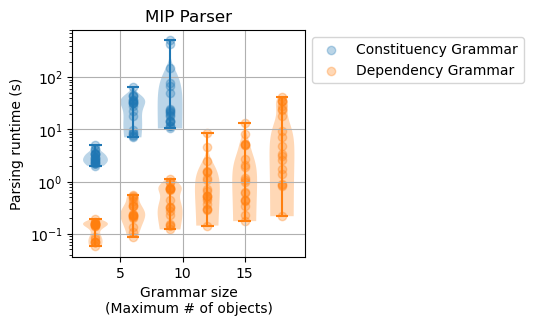

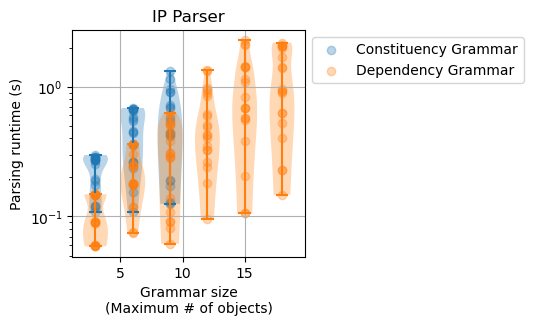

In [13]:
# Plot runtime scaling of each technique
for k, (strategy, superlabel) in enumerate(zip(["mip", "ip"], ["MIP Parser", "IP Parser"])):
    plt.figure(dpi=100).set_size_inches(3, 3)
    plt.title(superlabel)
    con_results = con_results_by_strategy[strategy]
    dep_results = dep_results_by_strategy[strategy]

    def plot_with_errorbars(xs, list_of_times, label):
        y = [np.mean(times) for times in list_of_times]
        y_std = [np.std(times) for times in list_of_times]
        parts = plt.violinplot(list_of_times, positions=xs, widths=2.)
        for pc in parts['bodies']:
            c = pc.get_facecolor()
            #pc.set_facecolor(c)
            #pc.set_edgecolor([0., 0., 0., 0])
        for k, (x, times) in enumerate(zip(xs, list_of_times)):
            if k == 0:
                thislabel = label
            else:
                thislabel = None
            plt.scatter(np.repeat(x, len(times)), times, c=c, label=thislabel)
    cm = plt.get_cmap("viridis")

    for results, label in zip([con_results, dep_results], ["Constituency Grammar", "Dependency Grammar"]):
        all_times = []
        xs = []
        for max_entities, info_list in results.items():
            all_times.append([
                info["mip_time"] for info in info_list
            ])
            xs.append(max_entities * 3) # Label with # of objects
        plot_with_errorbars(xs, all_times, label)

    plt.semilogy()
    #plt.ylim(0.01, 100.)
    plt.grid(True)
    plt.ylabel("Parsing runtime (s)")
    plt.xlabel("Grammar size\n(Maximum # of objects)")
    plt.legend(bbox_to_anchor=(1., 1.))

MIP Parser:Constituency Grammar MIP 0.200000 success, NLP 0.983333 success at matching or beating GT tree
MIP Parser:Dependency Grammar MIP 1.000000 success, NLP 1.000000 success at matching or beating GT tree
IP Parser:Constituency Grammar MIP 0.600000 success, NLP 1.000000 success at matching or beating GT tree
IP Parser:Dependency Grammar MIP 1.000000 success, NLP 1.000000 success at matching or beating GT tree


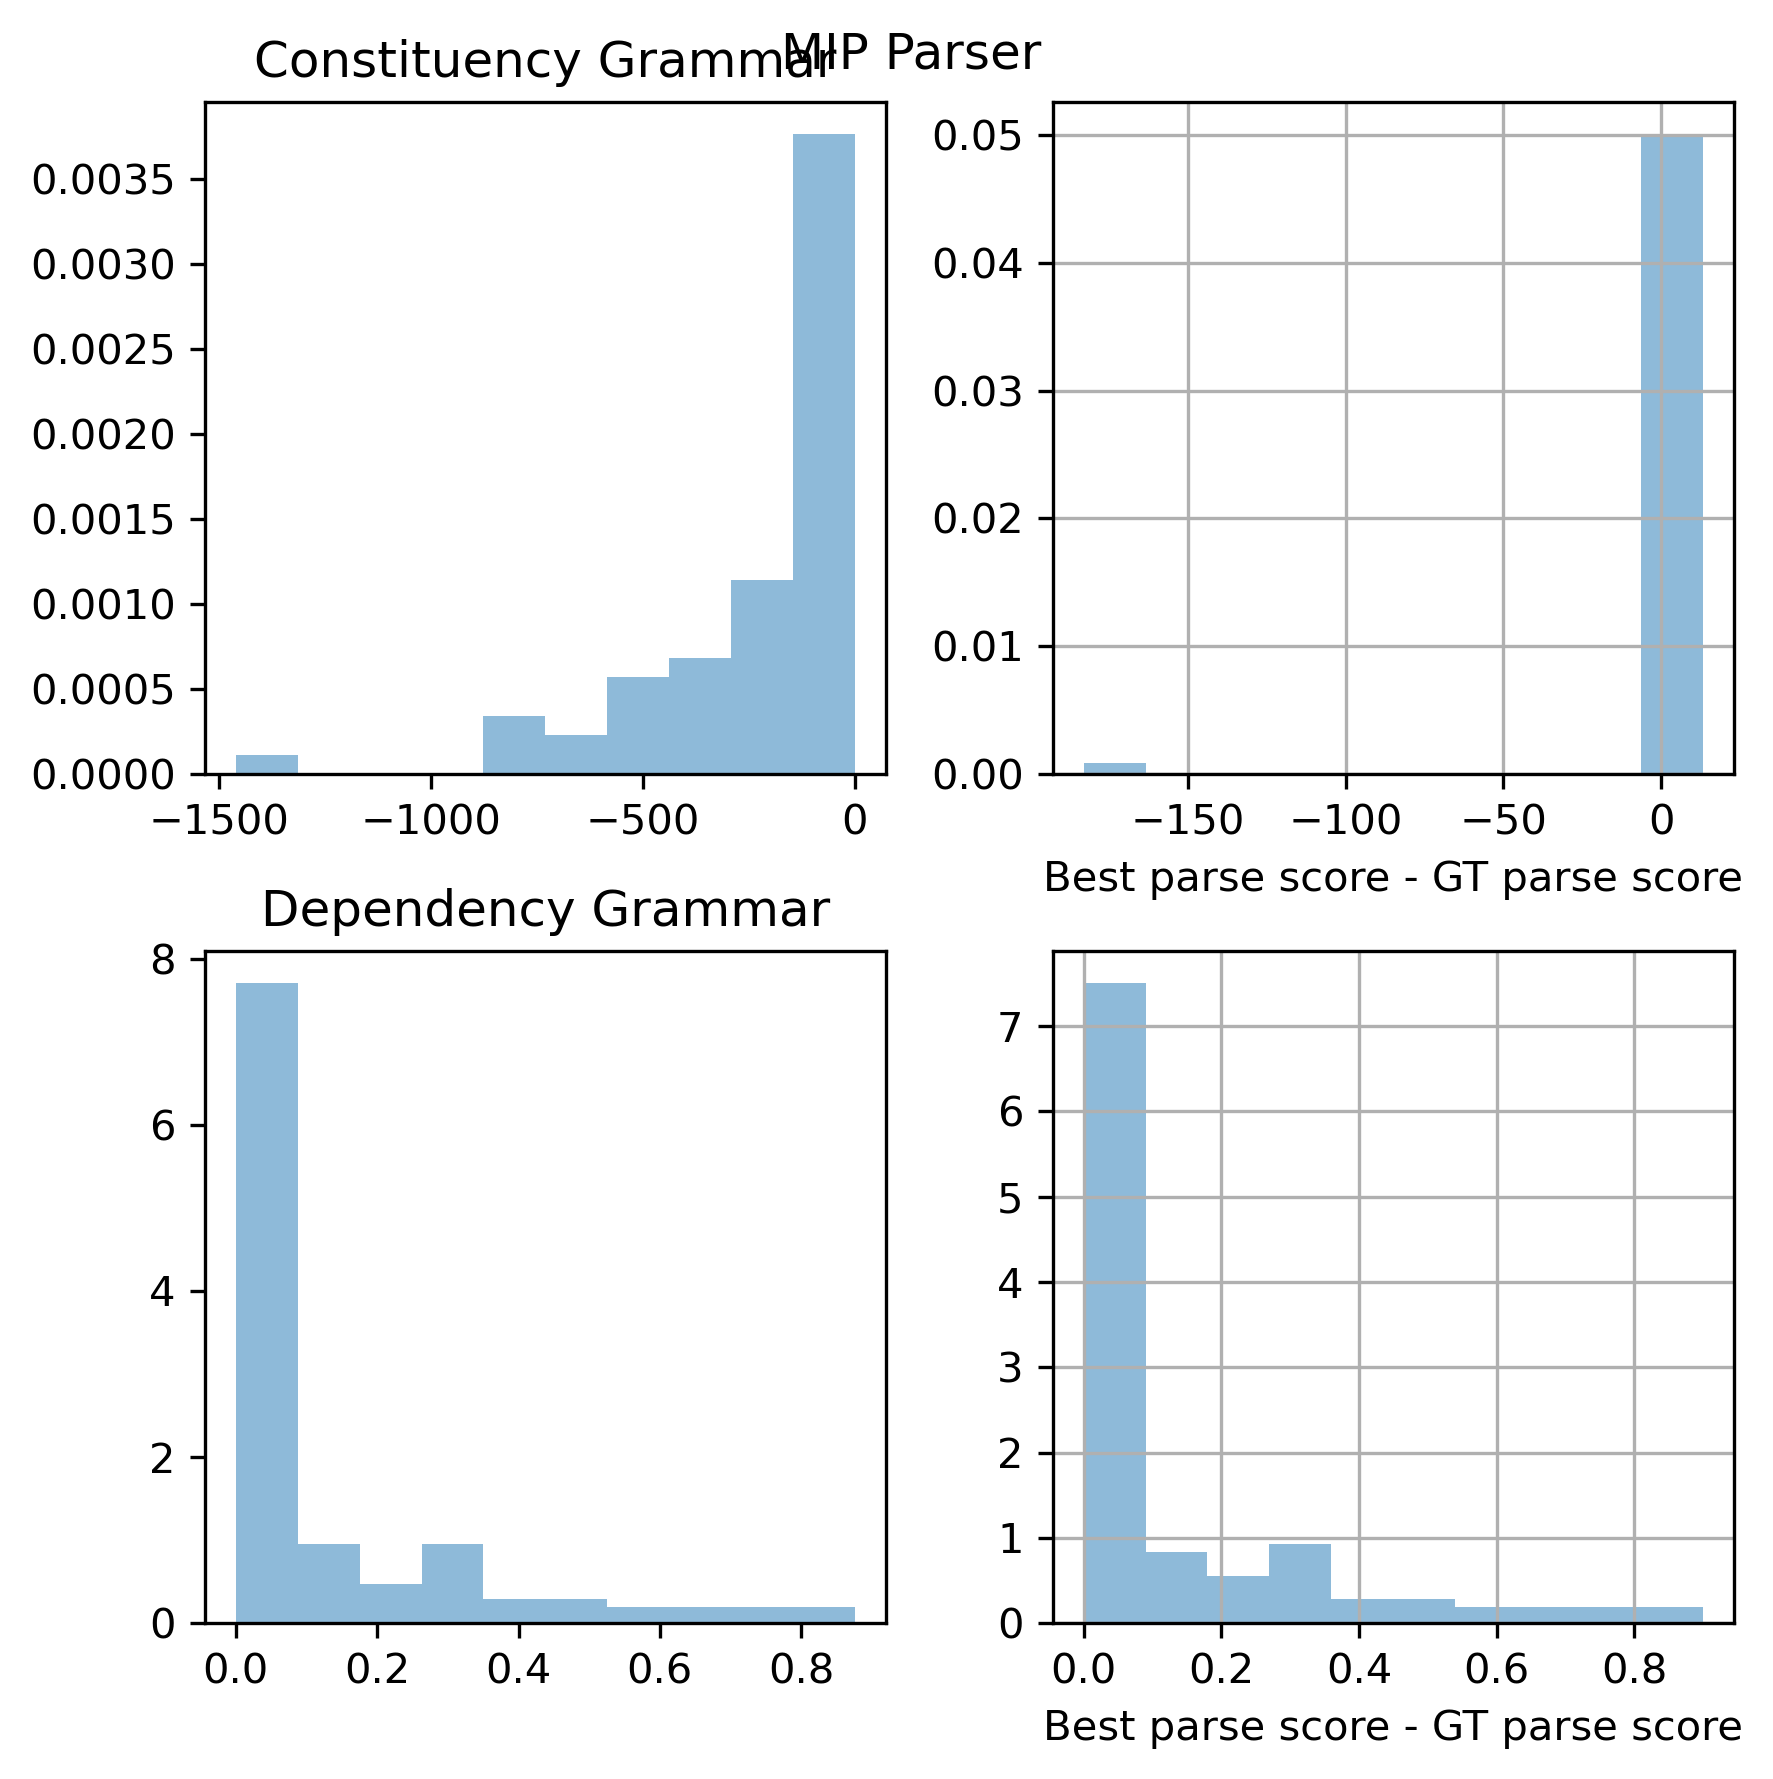

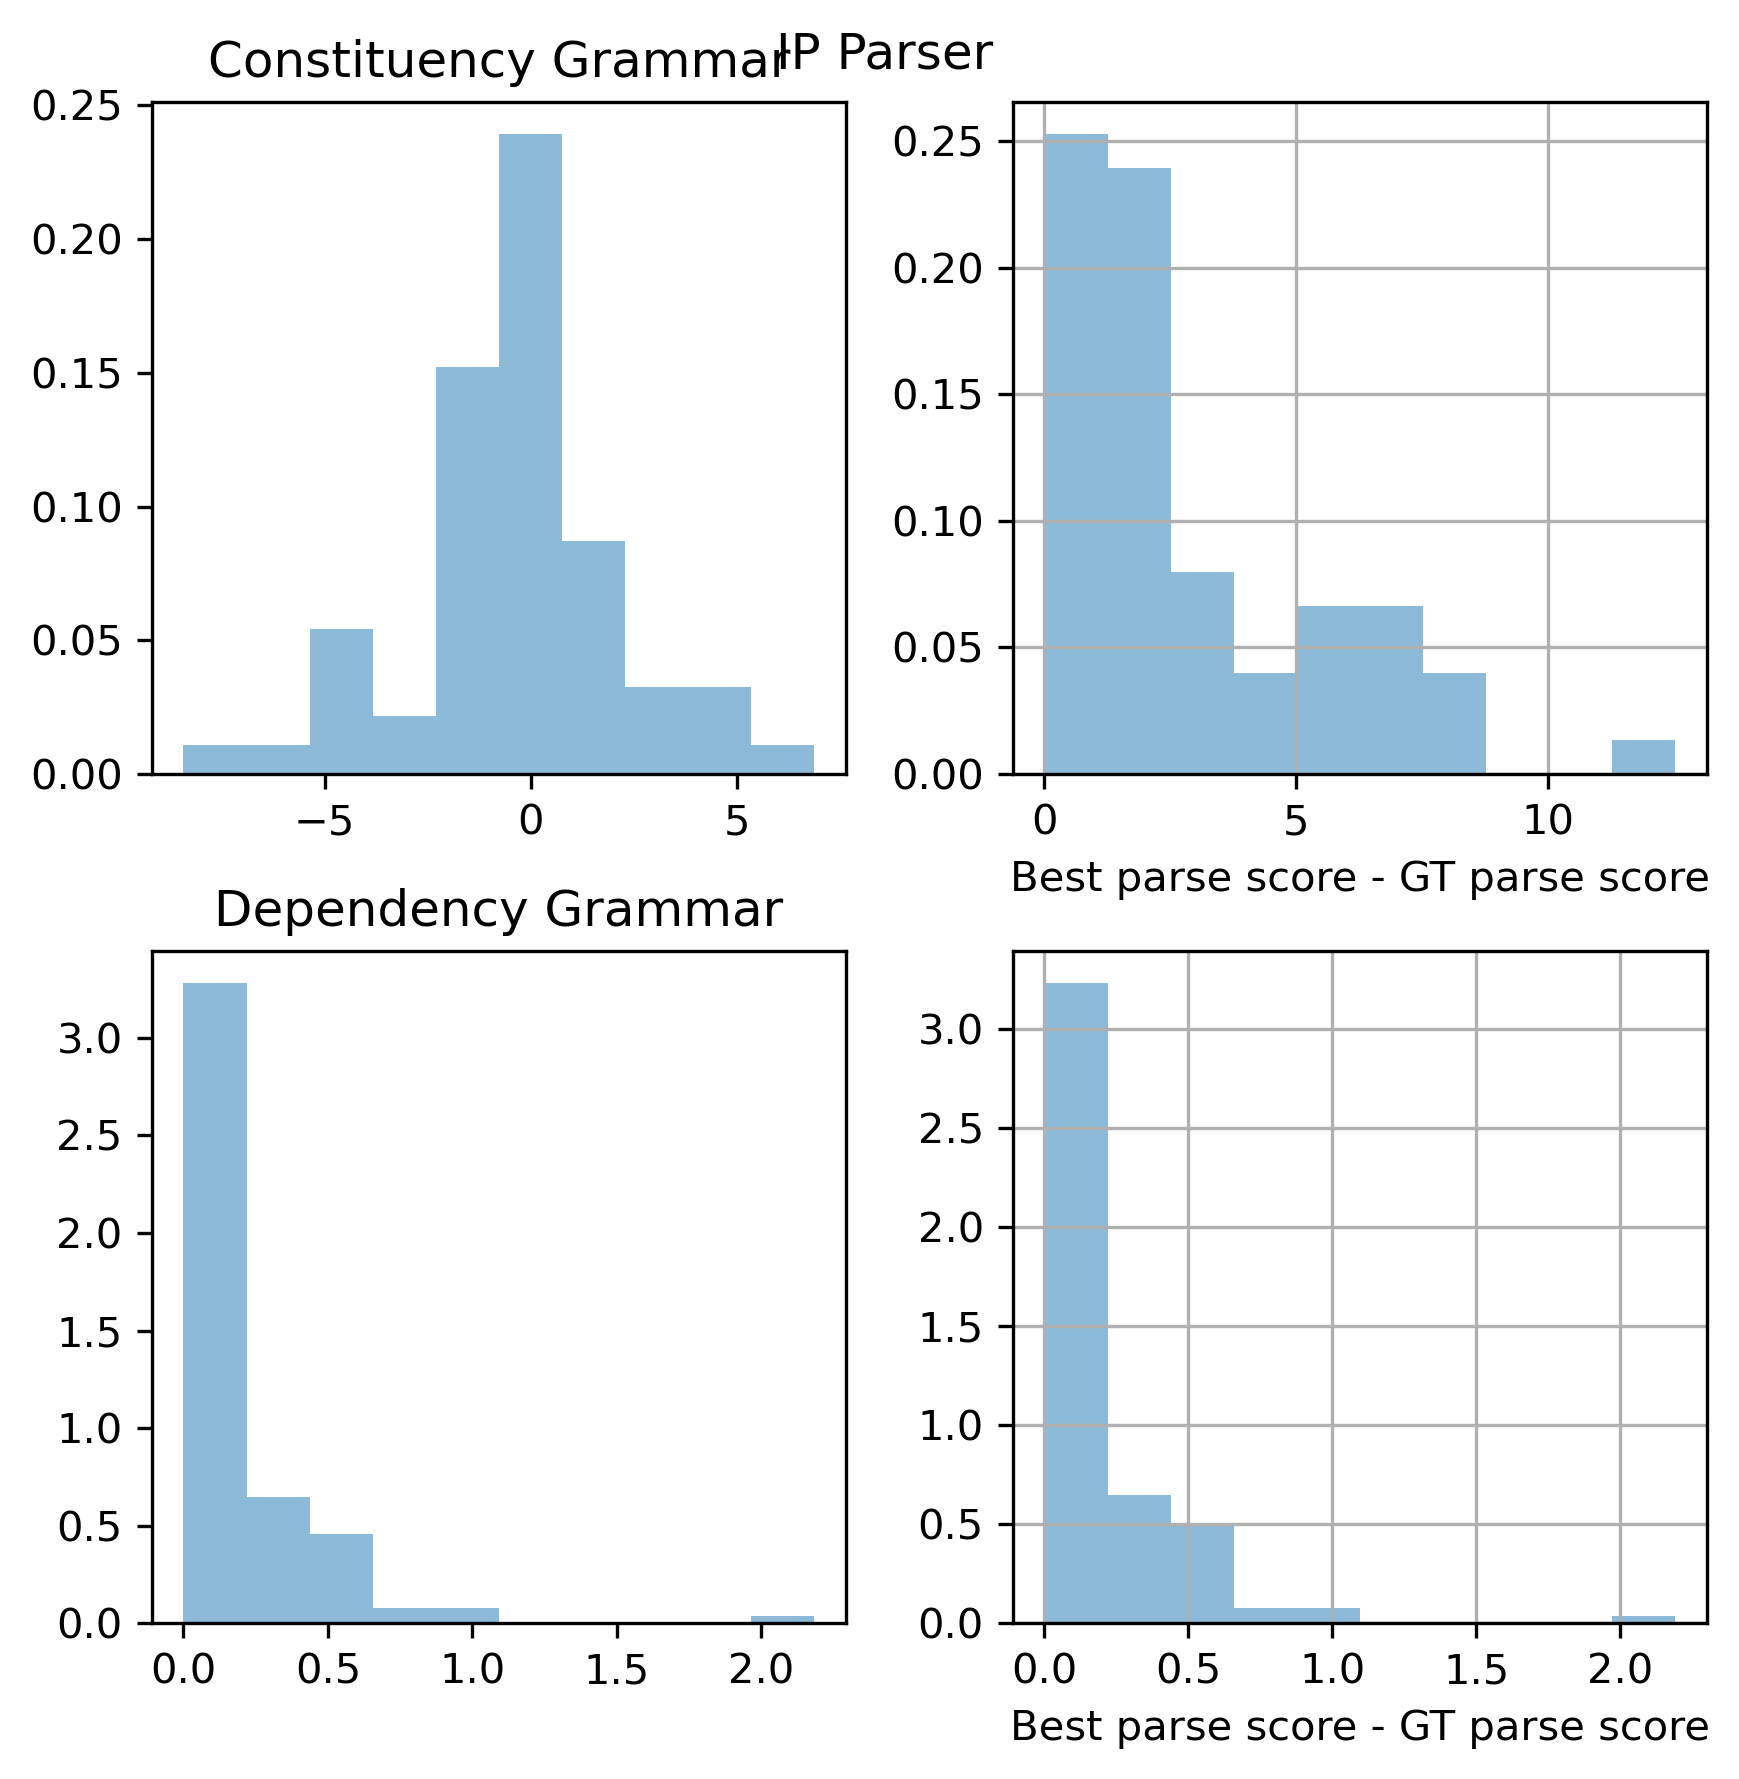

In [28]:
# For all examples we collected for each parse and grammar type,
# collect the histogram of the best parse score vs the ground truth
# tree score.
for i, (strategy, superlabel) in enumerate(zip(["mip", "ip"], ["MIP Parser", "IP Parser"])):
    plt.figure(dpi=300).set_size_inches(6, 6)
    plt.suptitle(superlabel)
    con_results = con_results_by_strategy[strategy]
    dep_results = dep_results_by_strategy[strategy]

    for j, (results, label) in enumerate(zip([con_results, dep_results], ["Constituency Grammar", "Dependency Grammar"])):
        plt.subplot(2, 2, 2*j+1)
        relative_mip_scores = []
        relative_nlp_scores = []
        for info_list in results.values():
            for info in info_list:
                relative_mip_scores.append(max(info["mip_tree_scores"]).item() - info["gt_tree_score"].item())
                relative_nlp_scores.append(max(info["nlp_tree_scores"]).item() - info["gt_tree_score"].item())
        if not all(np.isfinite(relative_mip_scores)):
            logging.error("Had infinite mip score?")
        plt.hist(relative_mip_scores, density=True, alpha=0.5, label="MIP")
        mip_success_ratio = sum(np.array(relative_mip_scores) >= -1E-3) / len(relative_mip_scores)
        plt.title(label)
        
        plt.subplot(2, 2, 2*j+2)
        if not all(np.isfinite(relative_nlp_scores)):
            logging.error("Had infinite nlp score?")
            relative_nlp_scores = np.array(relative_nlp_scores)[np.isfinite(relative_nlp_scores)]
        plt.hist(relative_nlp_scores, density=True, alpha=0.5, label="NLP")
        nlp_success_ratio = sum(np.array(relative_nlp_scores) >= -1E-3) / len(relative_nlp_scores)
        plt.grid(True)
        plt.xlabel("Best parse score - GT parse score")
        
        print("%s:%s MIP %f success, NLP %f success at matching or beating GT tree" % (superlabel, label, mip_success_ratio, nlp_success_ratio))

    plt.tight_layout()

# Visualize failed parses

In [19]:
failed_trees = []
for key, infos in con_results_by_strategy["mip"].items():
    for info in infos:
        if max(info["nlp_tree_scores"]) < -150:
            failed_trees.append((key, info))
            
print("Failed trees: ", failed_trees)
print("# of failed sets: ", len(failed_trees))

Failed trees:  [(2, {'gt_tree': <spatial_scene_grammars.scene_grammar.SceneTree object at 0x7fc9e5c740f0>, 'gt_tree_score': tensor([-2.3275]), 'mip_trees': [<spatial_scene_grammars.scene_grammar.SceneTree object at 0x7fc9ddb1e7f0>, <spatial_scene_grammars.scene_grammar.SceneTree object at 0x7fc9e2061d68>, <spatial_scene_grammars.scene_grammar.SceneTree object at 0x7fc9e15d6908>, <spatial_scene_grammars.scene_grammar.SceneTree object at 0x7fc9df1c1c88>, <spatial_scene_grammars.scene_grammar.SceneTree object at 0x7fc9d386c6a0>, <spatial_scene_grammars.scene_grammar.SceneTree object at 0x7fc9e54c0a90>, <spatial_scene_grammars.scene_grammar.SceneTree object at 0x7fc9d5c86da0>, <spatial_scene_grammars.scene_grammar.SceneTree object at 0x7fc9e4a16a20>, <spatial_scene_grammars.scene_grammar.SceneTree object at 0x7fc9e1c8b518>, <spatial_scene_grammars.scene_grammar.SceneTree object at 0x7fc9db9fc438>], 'mip_tree_scores': [tensor([-334.6235]), tensor([-334.6235]), tensor([-334.6235]), tensor([-

In [20]:
# Set up mushcat
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)

Meshcat url:  http://127.0.0.1:7001/static/


In [23]:
grammar_param, failed_info = failed_trees[0]

gt_tree = failed_info["gt_tree"]
failed_tree = failed_info["nlp_trees"][0]
bad_nlp_tree_score = failed_tree.score(verbose=True)
print(bad_nlp_tree_score)

Pairs.MAX_N_PAIRS = grammar_param
Pairs.P = 0.01 # Basically uniform distribution over # of pairs
Singles.MAX_N_SINGLES = grammar_param
Singles.P = 0.01 # Basically uniform distribution over # of pairs

draw_scene_tree_contents_meshcat(gt_tree, zmq_url=vis.window.zmq_url, prefix="gt_tree")
draw_scene_tree_structure_meshcat(gt_tree, zmq_url=vis.window.zmq_url, prefix="gt_tree_structure")
draw_scene_tree_structure_meshcat(failed_tree, zmq_url=vis.window.zmq_url, prefix="failed_tree_structure")
print("Score: ", failed_tree.score())

<spatial_scene_grammars_examples.singles_pairs.grammar_constituency.Root object at 0x7fc9d95dc470> :  -0.44628710262841953
XYZ:  0.0
Rot:  0.0
<spatial_scene_grammars_examples.singles_pairs.grammar_constituency.Root object at 0x7fc9d95dc470>  ->  <spatial_scene_grammars_examples.singles_pairs.grammar_constituency.Singles object at 0x7fc9d95dcf60> :  0.0
XYZ:  0.0
Rot:  0.0
<spatial_scene_grammars_examples.singles_pairs.grammar_constituency.Root object at 0x7fc9d95dc470>  ->  <spatial_scene_grammars_examples.singles_pairs.grammar_constituency.Pairs object at 0x7fc9e726e208> :  0.0
<spatial_scene_grammars_examples.singles_pairs.grammar_constituency.Singles object at 0x7fc9d95dcf60> :  -0.5306282510621702
XYZ:  -3.445051680751086
Rot:  -3.007617379721508
<spatial_scene_grammars_examples.singles_pairs.grammar_constituency.Singles object at 0x7fc9d95dcf60>  ->  <spatial_scene_grammars_examples.singles_pairs.grammar_constituency.Object object at 0x7fc9e1c8f3c8> :  -6.452669060472594
<spatial